In [1]:
!cp "/content/drive/My Drive/survcam/class.zip" "survdata.zip"

In [2]:
!unzip -q survdata.zip

In [3]:
import sys
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Concatenate, Flatten, MaxPooling2D, Convolution2D, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, LSTM, GRU, Bidirectional
from keras.regularizers import l2,l1
from keras.optimizers import SGD,Adam,RMSprop
from tensorflow.compat.v1 import InteractiveSession
import keras.backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model

In [7]:
import keras

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [9]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [11]:
from keras.utils import to_categorical, plot_model

In [12]:
class0 = os.listdir('class0')
class1 = os.listdir('class1')

In [13]:
len(class0),len(class1)

(212, 215)

In [14]:
#constructing label
label_0 = np.zeros((212,1))
label_1 = np.ones((215,1))

In [15]:
label = np.concatenate((label_0,label_1),axis=0)

In [16]:
label.shape

(427, 1)

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [18]:
Y = le.fit_transform(label).reshape(-1,1)
Y.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(427, 1)

In [19]:
samples = 427

In [20]:
dims = (123,123)
#ideal 4x28
#actual 54x390
shape_0 = (212, dims[0], dims[1], 1)
shape_1 = (215, dims[0], dims[1], 1)     

dataset_0 = np.zeros(shape=shape_0,dtype=np.float32)
dataset_1 = np.zeros(shape=shape_1,dtype=np.float32)

In [21]:
dataset_0.shape, dataset_1.shape

((212, 123, 123, 1), (215, 123, 123, 1))

In [22]:
#load off-target images
i=0
for item_0 in class0:
    img0 = load_img('class0/'+ item_0, target_size=dims, color_mode='grayscale',interpolation='nearest')  # this is a PIL image
    # Convert to Numpy Array
    x0 = img_to_array(img0)
    dataset_0[i] = x0
    i += 1
    if i % 100 == 0:
        print("%d images to array" % i)

print("All class_0 images done!")

100 images to array
200 images to array
All class_0 images done!


In [23]:
j=0
for item_1 in class1:
    img1 = load_img('class1/'+ item_1, target_size=dims, color_mode='grayscale',interpolation='nearest')  # this is a PIL image
    # Convert to Numpy Array
    x1 = img_to_array(img1)
    dataset_1[j] = x1
    j += 1
    if j % 100 == 0:
        print("%d images to array" % j)

print("All class_1 images done!")

100 images to array
200 images to array
All class_1 images done!


In [24]:
dataset_0.shape, dataset_1.shape

((212, 123, 123, 1), (215, 123, 123, 1))

In [25]:
dataset = np.concatenate((dataset_0,dataset_1),axis=0)

In [26]:
dataset.shape, Y.shape

((427, 123, 123, 1), (427, 1))

In [27]:
dataset_train, dataset_test, Y_train, Y_test, = train_test_split(dataset, Y,test_size=0.2, random_state=0)

In [28]:
indices = list(range(0,427))
indices_train,indices_test = train_test_split(indices, test_size=0.2, random_state=0)

In [29]:
dataset_train.shape, dataset_test.shape, Y_train.shape, Y_test.shape

((341, 123, 123, 1), (86, 123, 123, 1), (341, 1), (86, 1))

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
import gc
gc.collect()

54841

In [ ]:
#now model
try:
  del model, history
except:
  pass

In [30]:
#model
input_1  = Input(shape = (123,123,1))
conv_1   = Convolution2D(512, (3, 3), kernel_initializer='glorot_normal')(input_1)
bn_1     = BatchNormalization()(conv_1)
act_1    = Activation('relu')(bn_1)
pool_1   = MaxPooling2D(pool_size = (2,2))(act_1)

conv_2   = Convolution2D(512, (3, 3), kernel_initializer='glorot_normal')(pool_1)
bn_2     = BatchNormalization()(conv_2)
act_2    = Activation('relu')(bn_2)
pool_2   = MaxPooling2D(pool_size = (2,2))(act_2)

conv_3   = Convolution2D(512, (3, 3), kernel_initializer='glorot_normal')(pool_2)
bn_3     = BatchNormalization()(conv_3)
act_3    = Activation('relu')(bn_3)
pool_3   = MaxPooling2D(pool_size = (2,2))(act_3)

flatten = Flatten()(pool_3)

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(flatten)
dense_1_dropout = Dropout(0.5)(dense_1)
dense_2 = Dense(256, activation = 'relu',kernel_initializer='glorot_normal')(dense_1_dropout)
dense_2_dropout = Dropout(0.2)(dense_2)
dense_3 = Dense(128, activation = 'relu',kernel_initializer='glorot_normal')(dense_2_dropout)
output   = Dense(1, activation = 'sigmoid')(dense_3)

model = Model(inputs=input_1, outputs=output)

In [31]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 123, 123, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 121, 121, 512)     5120      
_________________________________________________________________
batch_normalization (BatchNo (None, 121, 121, 512)     2048      
_________________________________________________________________
activation (Activation)      (None, 121, 121, 512)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 512)       2359808   
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 58, 512)      

In [32]:
metrics = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc")
]

In [33]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),loss='binary_crossentropy',metrics=metrics)

In [34]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=5, min_lr=0.00000001, verbose=1)

In [35]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10,restore_best_weights=True, verbose=1)

In [36]:
history=model.fit(dataset_train, Y_train, 
                batch_size=32, 
                epochs=40, 
                verbose=1,
                validation_data=(dataset_test,Y_test),
                #validation_split=0.1,
                callbacks=[reduce_lr,early_stopping],
                )

Epoch 1/40
11/11 [==============================] - 4s 342ms/step - loss: 3.3266 - accuracy: 0.4897 - precision: 0.5080 - recall: 0.5367 - auc: 0.4822 - val_loss: 7.7437 - val_accuracy: 0.4419 - val_precision: 0.4419 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/40
11/11 [==============================] - 2s 155ms/step - loss: 2.3136 - accuracy: 0.5455 - precision: 0.5663 - recall: 0.5311 - auc: 0.5548 - val_loss: 2.4295 - val_accuracy: 0.4419 - val_precision: 0.4419 - val_recall: 1.0000 - val_auc: 0.7755
Epoch 3/40
11/11 [==============================] - 2s 174ms/step - loss: 1.9230 - accuracy: 0.5572 - precision: 0.5793 - recall: 0.5367 - auc: 0.5849 - val_loss: 0.5228 - val_accuracy: 0.6628 - val_precision: 0.5918 - val_recall: 0.7632 - val_auc: 0.8462
Epoch 4/40
11/11 [==============================] - 2s 164ms/step - loss: 1.3045 - accuracy: 0.6158 - precision: 0.6198 - recall: 0.6723 - auc: 0.6698 - val_loss: 0.5397 - val_accuracy: 0.7326 - val_precision: 1.0000 - val_recall: 0

In [37]:
model.save('model_latest.hdf5')

In [38]:
!cp "model_latest.hdf5" "/content/drive/My Drive/survcam/"

In [39]:
# predict on test set
Y_pred = model.predict(dataset_test)

In [40]:
#plots
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

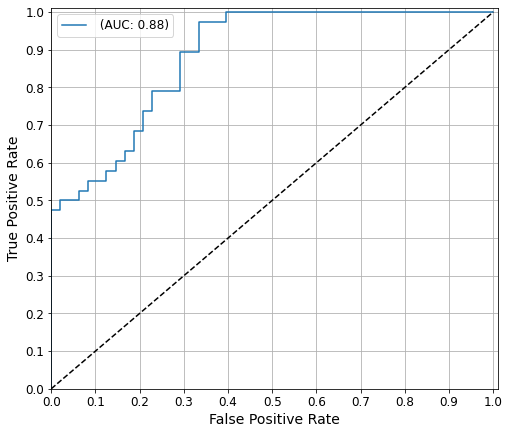

In [41]:
# Plot of a ROC curve for a specific class
fig, ax = plt.subplots(figsize=(8,7))
ax.plot(fpr[0], tpr[0],label=' (AUC: %0.2f)' % roc_auc[0], alpha=1)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.01])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid()
ax.legend(fontsize=12)
plt.savefig('roc.png', dpi=500, bbox_inches='tight')

In [42]:
precision = dict()
recall = dict()
average_precision = dict()
for i in range(1):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], Y_pred[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], Y_pred[:, i])

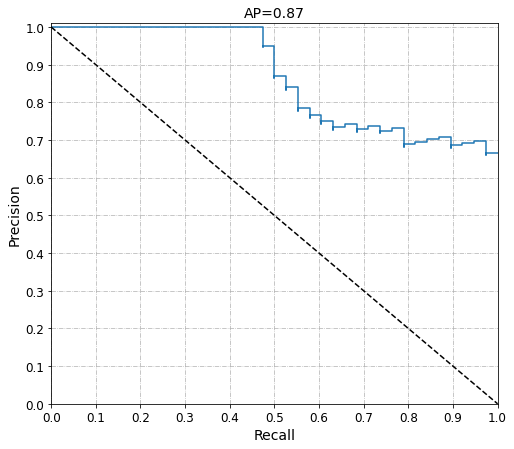

In [43]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), Y_pred.ravel())
average_precision["micro"] = average_precision_score(Y_test, Y_pred, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

fig, ax = plt.subplots(figsize=(8,7))
ax.step(recall['micro'], precision['micro'], where='post')

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.plot([0, 1], [1, 0], 'k--')
ax.set_ylim([0.0, 1.01])
ax.set_xlim([0.0, 1.00])
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_title('AP={0:0.2f}'.format(average_precision["micro"]), fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12) 
ax.grid(linestyle='-.', linewidth=0.7)
plt.savefig('aupr.png', dpi=500, bbox_inches='tight')

In [45]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics as sklearn_metrics

In [46]:
y_label_pred = np.where(Y_pred > 0.5, 1, 0)

In [47]:
print(sklearn_metrics.confusion_matrix(Y_test, y_label_pred))

[[34 14]
 [ 4 34]]


In [48]:
tn, fp, fn, tp = sklearn_metrics.confusion_matrix(Y_test, y_label_pred).ravel()
print(tn, fp, fn, tp)

34 14 4 34


In [49]:
print(sklearn_metrics.classification_report(Y_test, y_label_pred, digits=3))

              precision    recall  f1-score   support

           0      0.895     0.708     0.791        48
           1      0.708     0.895     0.791        38

    accuracy                          0.791        86
   macro avg      0.802     0.802     0.791        86
weighted avg      0.812     0.791     0.791        86



In [ ]:
#gradcams

In [50]:
!pip install tf-keras-vis

In [ ]:
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


In [51]:
Y_pred.shape

(86, 1)

In [52]:
print(indices_test)
print(Y_pred)

[274, 159, 54, 309, 10, 367, 176, 328, 259, 190, 21, 315, 122, 420, 221, 252, 353, 219, 317, 332, 345, 191, 349, 1, 37, 134, 65, 158, 308, 12, 194, 186, 416, 319, 198, 154, 96, 316, 346, 218, 289, 153, 360, 224, 15, 393, 60, 170, 196, 113, 357, 369, 6, 90, 150, 325, 102, 76, 375, 145, 199, 59, 347, 336, 412, 175, 78, 271, 141, 387, 155, 160, 107, 391, 341, 124, 49, 52, 74, 26, 45, 144, 4, 225, 368, 100]
[[0.503618  ]
 [0.50765294]
 [0.21652044]
 [0.77605927]
 [0.742055  ]
 [0.76347506]
 [0.33601055]
 [0.88133824]
 [0.8107272 ]
 [0.07669333]
 [0.34870577]
 [0.7308716 ]
 [0.4104275 ]
 [0.76619   ]
 [0.85114616]
 [0.5733362 ]
 [0.588519  ]
 [0.8428068 ]
 [0.5487667 ]
 [0.6500707 ]
 [0.8380298 ]
 [0.65624154]
 [0.7630821 ]
 [0.66524386]
 [0.2720088 ]
 [0.32161352]
 [0.43976697]
 [0.14498444]
 [0.81624025]
 [0.35906526]
 [0.5365633 ]
 [0.49230054]
 [0.8502999 ]
 [0.75511855]
 [0.29138315]
 [0.69855624]
 [0.28345996]
 [0.48096034]
 [0.9132234 ]
 [0.46365032]
 [0.42174307]
 [0.7219323 ]
 [0.8

In [ ]:
#indices to check
#class_1 =  8,17,20
#class_0 =  85,76,75

In [53]:
print(indices_test[8],indices_test[17],indices_test[20])
print(indices_test[85],indices_test[76],indices_test[75])

259 219 345
100 49 124


In [137]:
cimg = dataset[124]

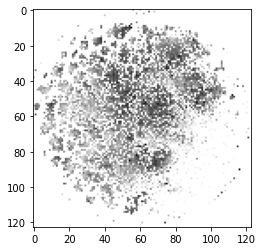

In [138]:
plt.imshow(cimg.squeeze(), cmap='gray')

In [83]:
def loss(output):
    return (output[0][0])

In [57]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

In [58]:
# Rendering
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }

In [59]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

In [60]:
saliency = Saliency(model,
                    model_modifier=model_modifier,
                    clone=True)

# Generate saliency map


In [139]:
saliency_map = saliency(loss, cimg)
saliency_map = normalize(saliency_map)

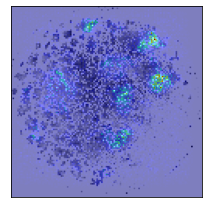

In [140]:
f, ax = plt.subplots(**subplot_args)
ax.imshow(saliency_map.squeeze(), cmap='jet')
ax.imshow(cimg.squeeze(), cmap='gray', alpha=0.5)
plt.tight_layout()
plt.show()

In [128]:
saliency_map = saliency(loss,
                        cimg,
                        smooth_samples=30, # The number of calculating gradients iterations.
                        smooth_noise=0.20) # noise spread level.
saliency_map = normalize(saliency_map)

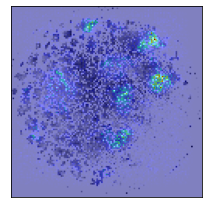

In [141]:
f, ax = plt.subplots(**subplot_args)
ax.imshow(cimg.squeeze(), cmap='gray')
ax.imshow(saliency_map.squeeze(), cmap='jet', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#gradcam

In [65]:
model.layers

In [66]:
from tf_keras_vis.gradcam import Gradcam,GradcamPlusPlus

In [156]:
gradcam = GradcamPlusPlus(model,
                  model_modifier=model_modifier,
                  clone=True)

In [176]:
cam = gradcam(loss,
              cimg,
              penultimate_layer=5, # model.layers number
             )
cam = normalize(cam)

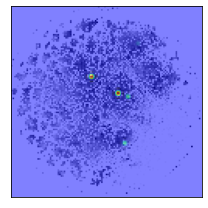

In [177]:
f, ax = plt.subplots(**subplot_args)
ax.imshow(cimg.squeeze(), cmap='gray')
ax.imshow(cam.squeeze(), cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()

In [ ]:
#score cam

In [77]:
from tf_keras_vis.scorecam import ScoreCAM

In [78]:
scorecam = ScoreCAM(model, model_modifier, clone=True)

In [165]:
cam = scorecam(loss,
              cimg,
              penultimate_layer=-1, # model.layers number
             )
cam = normalize(cam)

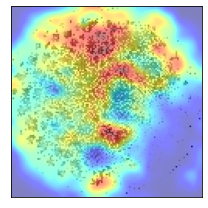

In [166]:
f, ax = plt.subplots(**subplot_args)
#heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
ax.imshow(cimg.squeeze(), cmap='gray')
ax.imshow(cam.squeeze(), cmap='jet', alpha=0.5) # overlay
plt.tight_layout()
plt.show()